In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import scipy.optimize as spo
plt.style.use('seaborn')

#### Unimportant Warnings

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

#### Custom Files

In [3]:
from data_io import DataIO # Custom IO file

# Input/Output of RGA and Temperature Data

In [4]:
Path = os.getcwd() + "/data/2020_11_09/" # data file path

In [5]:
IO = DataIO(Path)

In [6]:
IO.Unzip()

In [ ]:
RGA_Data = IO.GetRGAData()

In [8]:
Temp = IO.GetTemperatureData()

In [9]:
#data.to_hdf(p+"10_19_rga_2020.h5", key='data')

In [10]:
RGA_Data

,Datetime,Mass,Pressure
0,2020-11-09 16:59:53,1,1.93e-09
1,2020-11-09 16:59:53,1.1,3.31e-09
2,2020-11-09 16:59:53,1.2,6.48e-08
3,2020-11-09 16:59:53,1.3,2.31e-07
4,2020-11-09 16:59:53,1.4,4.75e-08
...,...,...,...
5517883,2020-11-12 00:59:28,99.6,-1.68e-10
5517884,2020-11-12 00:59:28,99.7,-1.09e-10
5517885,2020-11-12 00:59:28,99.8,-9.69e-11
5517886,2020-11-12 00:59:28,99.9,-9.48e-11


In [11]:
Temp

,Date,Time,CH1,CH2,Datetime
0,11/10/2020,1:19:00,20.3,20.2,2020-11-10 01:19:00
1,11/10/2020,1:19:01,20.3,20.3,2020-11-10 01:19:01
2,11/10/2020,1:19:02,20.3,20.3,2020-11-10 01:19:02
3,11/10/2020,1:19:03,20.3,20.3,2020-11-10 01:19:03
4,11/10/2020,1:19:04,20.3,20.3,2020-11-10 01:19:04
...,...,...,...,...,...
189796,11/12/2020,9:34:07,20.4,20.3,2020-11-12 09:34:07
189797,11/12/2020,9:34:08,20.4,20.3,2020-11-12 09:34:08
189798,11/12/2020,9:34:09,20.4,20.3,2020-11-12 09:34:09
189799,11/12/2020,9:34:10,20.4,20.3,2020-11-12 09:34:10


### Times

In [12]:
# Starting RGA Time.
rga_start = RGA_Data['Datetime'].sort_values().unique()[0]

In [13]:
# Starting temperature time.
temps_start = Temp['Datetime'].sort_values().unique()[0]

In [14]:
# Find the EARLIEST time to calculate timedeltas from.
if rga_start < temps_start:
    start_datetime = rga_start
else:
    start_datetime = temps_start

In [15]:
start_datetime

numpy.datetime64('2020-11-09T16:59:53.000000000')

In [16]:
temp_times = (Temp['Datetime'] - start_datetime)/np.timedelta64(1, 's')

In [17]:
# Separate by mass
H2_data = RGA_Data[RGA_Data['Mass'] == 2.0]
H2O_data = RGA_Data[RGA_Data['Mass'] == 18.0]
N2_data = RGA_Data[RGA_Data['Mass'] == 28.0]
O2_data = RGA_Data[RGA_Data['Mass'] == 32.0]
CO2_data = RGA_Data[RGA_Data['Mass'] == 44.0]

In [18]:
rga_times = (RGA_Data['Datetime'].unique() - start_datetime)/np.timedelta64(1, 's')
H2_times = (H2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
H2O_times = (H2O_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
N2_times = (N2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
O2_times = (O2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
CO2_times = (CO2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')

### Temperature Interpolation

In [19]:
O2_ch1_lerp = np.interp(O2_times, temp_times, pd.to_numeric(Temp['CH1']))
O2_ch2_lerp = np.interp(O2_times, temp_times, pd.to_numeric(Temp['CH2']))

### Final Data Frames

In [20]:
## Build O2 final data frame
O2_final_data = pd.DataFrame(data=O2_times)
# Microtorr now
O2_final_data['O2_Pressure'] = O2_data['Pressure']
# Celsius to Kelvin
O2_final_data['ch1_lerp'] = O2_ch1_lerp + 273.2
O2_final_data['ch2_lerp'] = O2_ch2_lerp + 273.2
O2_final_data['temp_est'] = (O2_final_data['ch1_lerp'] + O2_final_data['ch2_lerp'])/2.0
O2_final_data

,Datetime,O2_Pressure,ch1_lerp,ch2_lerp,temp_est
310,0.0,1.68e-06,293.5,293.4,293.45
1301,41.0,1.61e-06,293.5,293.4,293.45
2292,83.0,1.53e-06,293.5,293.4,293.45
3283,124.0,1.45e-06,293.5,293.4,293.45
4274,166.0,1.37e-06,293.5,293.4,293.45
...,...,...,...,...,...
5513243,201409.0,7.62e-08,293.7,293.5,293.60
5514234,201451.0,7.51e-08,293.7,293.5,293.60
5515225,201492.0,7.55e-08,293.7,293.5,293.60
5516216,201534.0,7.53e-08,293.7,293.5,293.60


### Curve Fitting
$$p(t,T) = A\cdot \exp\left(-\frac{b}{T}\right)\cdot\exp\left(-c\cdot t\cdot \exp\left(-\frac{b}{T}\right)\right)$$

In [21]:
def pressure_fit(tT, A, b, c):
    # (k,M) array if there are k predictors
    factor = np.exp(-1.0*b/tT[1])
    return A * factor * np.exp(-1.0*c*tT[0]*factor)

In [22]:
O2_jump1 = O2_final_data[O2_final_data['Datetime'].between(51000, 65000)]

In [23]:
O2_Tdata = O2_jump1[['Datetime', 'temp_est']].T.to_numpy()
O2_Tdata.shape

(2, 338)

In [24]:
# Initial guess of uncertainties
#O2_sigma = np.empty(O2_Tdata.shape[1]); O2_sigma.fill(1e-9)
#O2_sigma.shape

In [25]:
popt, pcov = spo.curve_fit(pressure_fit, O2_Tdata, O2_jump1['O2_Pressure'], p0=[50, 5800, 980], bounds=([-np.inf, -np.inf, 0],np.inf), maxfev=8000)

In [26]:
popt

array([5.0e+01, 5.8e+03, 1.0e+00])

In [27]:
pcov

array([[ 27718.7165281 , 161971.29164393,  67187.94834947],
       [161971.29164393, 946600.96669068, 390931.17628262],
       [ 67187.94834947, 390931.17628262, 183421.94459286]])

In [28]:
fit_vals = pressure_fit(O2_Tdata, popt[0], popt[1], popt[2])
#fit_vals

In [29]:
O2_jump4 = O2_final_data[O2_final_data['Datetime'].between(110000, 150000)]

In [30]:
O2_4T = O2_jump4[['Datetime', 'temp_est']].T.to_numpy()
O2_4T.shape

(2, 965)

In [31]:
popt, pcov = spo.curve_fit(pressure_fit, O2_4T, O2_jump4['O2_Pressure'], p0=[15, 5800, 1], bounds=([-np.inf, -np.inf, 0],np.inf), maxfev=8000)

In [32]:
popt

array([1.5e+01, 5.8e+03, 1.0e+00])

In [33]:
pcov

array([[4.64761375e+02, 1.00113163e+04, 2.28965095e+02],
       [1.00113163e+04, 2.15720653e+05, 4.86178341e+03],
       [2.28965095e+02, 4.86178341e+03, 1.85127280e+02]])

In [34]:
O2_4_fits = pressure_fit(O2_4T, popt[0], popt[1], popt[2])

### Plotting

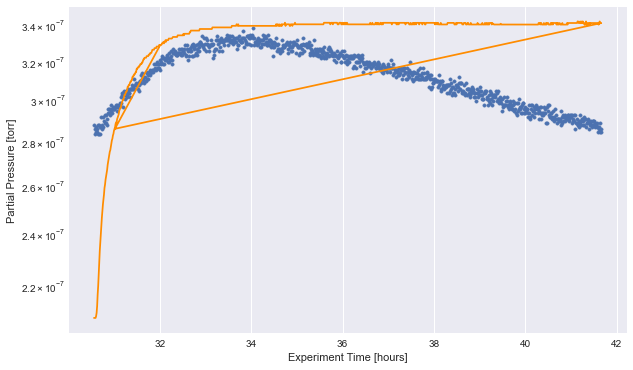

In [35]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(O2_jump4['Datetime']/3600, O2_jump4['O2_Pressure'], marker='.')
ax.plot(O2_jump4['Datetime']/3600, O2_4_fits, color='darkorange')
ax.set_ylabel('Partial Pressure [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.set_yscale('log')

plt.show()

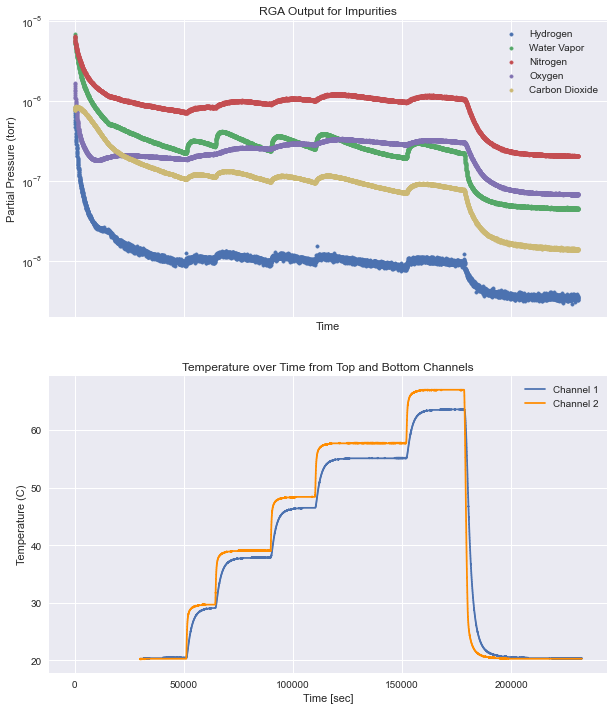

In [36]:
fig, ax = plt.subplots(figsize=(10,12),  nrows = 2, sharex=True)
ax[0].scatter(H2_times, H2_data['Pressure'], marker='.', label='Hydrogen')
ax[0].scatter(H2O_times, H2O_data['Pressure'], marker='.', label='Water Vapor')
ax[0].scatter(N2_times, N2_data['Pressure'], marker='.', label='Nitrogen')
ax[0].scatter(O2_times, O2_data['Pressure'], marker='.', label='Oxygen')
ax[0].scatter(CO2_times, CO2_data['Pressure'], marker='.', label='Carbon Dioxide')
ax[0].set_title('RGA Output for Impurities')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Partial Pressure (torr)')
ax[0].legend()
ax[0].set_yscale('log')

ax[1].plot(temp_times, pd.to_numeric(Temp['CH1']), label='Channel 1')
ax[1].plot(temp_times, pd.to_numeric(Temp['CH2']), label='Channel 2', color='darkorange')
ax[1].set_title('Temperature over Time from Top and Bottom Channels')
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel('Temperature (C)')
ax[1].legend()

fig.savefig('plot_out_2020_11_09.png', dpi=300)
plt.show()

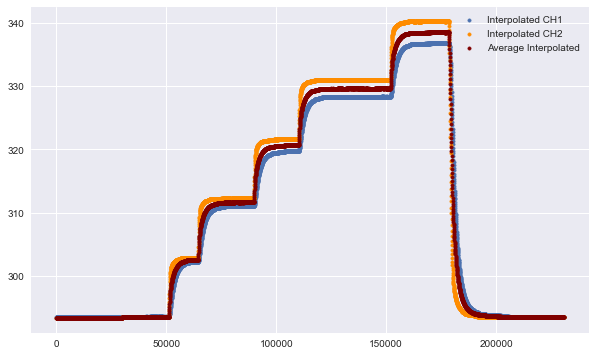

In [41]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(O2_times, O2_final_data['ch1_lerp'], marker='.', label='Interpolated CH1')
ax.scatter(O2_times, O2_final_data['ch2_lerp'], marker='.', label='Interpolated CH2', color='darkorange')
ax.scatter(O2_final_data['Datetime'], O2_final_data['temp_est'], marker='.', label='Average Interpolated', color='maroon')
ax.legend()

plt.show()